In [1]:
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
import networkx as nx
from networkx.algorithms import approximation
import random
from prettytable import PrettyTable

In [2]:
# constants for the waste removal network (will later be used in the graphs)
farm = -1
hq = -2
drop_site = -3

class Truck:
    """
    Implements truck functionality along with the calculation of related metrics. 
    """
    def __init__(self, fuel_amt = 50, full_space_proportion = 0, cur_location = 0, 
                 time = 0, collected = 0, gas_used = 0, driving_time = 0):
        """
        Initializes basic properties of the truck.
        ------------------------------------------------
        fuel_amt(int):
            amount of fuel left in the tank (measured in gallons)
        full_space_proportion (float):
            proportion of full space in the truck (how much left to fill with waste) 
        cur_location (int):
            number of the node where the truck is at the moment
        time (int):
            total amount of time the truck has been operating for
        collected (float):
            total amount of waste collected by the truck (relative to its full capacity)
        gas_used (int):
            total amount of gas used within the whole period of the truck operating
        driving_time (float):
            total amount of time the truck spent driving (measured in hours)
        """
        self.fuel_amt = fuel_amt
        self.full_space_proportion = full_space_proportion
        self.cur_location = cur_location
        self.time = time
        self.collected = collected
        self.gas_used = gas_used
        self.driving_time = driving_time
        self.dumps_visited = 0
        
        
    def calculate_driving_time(self, graph, cur, nxt, speed = 16):
        """
        Calculates the driving time for a specific route when the
        truck moves between 2 points.
        ------------------------------------------------
        graph (networkx object):
            whole area including farms, hq, and drop-off site
        cur (networkx object):
            current node in the network where the truck is located (departure point)
        nxt (networkx object):
            next node in the network where the truck is headed (arrival point)
        speed (int):
            speed of a garbage truck (measured in miles per hour)
        """
        # if the algorithm refers to a node by its number
        # (only one case when the truck needs to refuel)
        if type(nxt) == int:
            road = graph.edges[cur['location'], 0]['distance']
        else:  
            # retrieve the distance between two points
            distance = graph.edges[cur['location'], nxt['location']]['distance']
        return distance / speed
        
        
    def calculate_gas_spent(self, graph, cur, nxt, consumption = 0.23):
        """
        Calculates the amount of gas spent for a specific route 
        when the truck moves between 2 points.
        ------------------------------------------------
        graph (networkx object):
            whole area including farms, hq, and drop-off site
        cur (networkx object):
            current node in the network where the truck is located (departure point)
        nxt (networkx object):
            next node in the network where the truck is headed (arrival point)
        consumption (float):
            average fuel consumption of a garbage truck (measured in gallons per mile)
        """
        # if the algorithm refers to a node by its number
        # (only one case when the truck needs to refuel)
        if type(nxt) == int:
            distance = graph.edges[cur['location'], 0]['distance']
        else:
            # retrieve the distance between two points
            distance = graph.edges[cur['location'], nxt['location']]['distance']
        return 0.33 * distance
    
    
    def update_driving_time(self, graph, cur, nxt):
        """
        Updates the driving time and other truck-related attributes
        when the truck is on the road.
        ------------------------------------------------
        graph (networkx object):
            whole area including farms, hq, and drop-off site
        cur (networkx object):
            current node in the network where the truck is located (departure point)
        nxt (networkx object):
            next node in the network where the truck is headed (arrival point)
        """
        # calculate time spent on moving between two points
        road_time = self.calculate_driving_time(graph, cur, nxt)
        # increase the overall and driving time
        self.time += road_time
        self.driving_time += road_time
        # calculate gas spent on moving between two points
        road_gas = self.calculate_gas_spent(graph, cur, nxt)
        # adjust related metrics
        self.fuel_amt -= road_gas
        self.gas_used += road_gas
        # refuel the truck if the next stop is hq
        if nxt['type'] == hq:
            self.fuel_amt = 50
        
        
    def load_waste_farm(self, nxt):
        """
        Updates driving time and other truck-related attributes
        when the truck is at the farm.
        ------------------------------------------------
        nxt (networkx object):
            next node in the network where the truck is headed (arrival point)
        """
        # determine the amount of waste to pick up
        waste_to_pickup = nxt['waste']
        # update all relevant metrics (time, waste collected, free space amount)
        self.time += waste_to_pickup * 0.33
        self.collected += waste_to_pickup
        self.full_space_proportion += waste_to_pickup
        
        
    def unload_waste_dropoff(self):
        """
        Updates driving time and other truck-related attributes
        when the truck is at the dropoff site.
        ------------------------------------------------
        """
        # adjust the time value
        self.time += self.full_space_proportion * 0.16
        # make sure the truck is empty
        self.full_space_proportion = 0    

In [3]:
class WasteRemovalSimulation:
    """
    Implements the waste removal simulation.
    """
    def __init__(self, n, max_waste, strategy, dropoff):
        """
        Initializes basic properties of the waste removal simulation.
        ----------------------------------
        n (int):
            number of nodes in the graph
        max_waste (float):
            maximum waste amount that can be present on 1 farm 
            (measured as a proportion of a truck capacity)
        strategy (str):
            strategy for the simulation (random or greedy)
        dropoff (int):
            number of dropoff sites in the system
        """
        self.n = n
        self.dropoff = dropoff 
        self.max_waste = max_waste
        # truck(s) operating in the system
        self.truck = Truck() 
        self.strategy = strategy
        # order of the nodes to visit (available in greedy mode)
        self.node_order = None
        self.network = self.create_network()
        # dictionary with nodes as keys and positions as values
        self.network.pos = nx.spring_layout(self.network)
        
        
    def create_network(self):
        """
        Initializes the network.
        """
        # calculations required for truncated normal distribution parameters
        lower_bound, upper_bound = 0, 2
        mean, std = 1, 0.3
        a, b = (lower_bound - mean) / std, (upper_bound - mean) / std
        # will be used later for graphing
        graph = nx.complete_graph(self.n)
        # initialize hq
        graph.nodes[0]['type'] = hq
        # initialize drop-off site(s)
        for i in range(self.dropoff+1):
            graph.nodes[i+1]['type'] = drop_site
        # initialize farms
        for node, idx in zip(graph.nodes, range(self.n)):
            graph.nodes[node]['location'] = idx
            if idx > self.dropoff:
                graph.nodes[node]['type'] = farm
                graph.nodes[node]['waste'] = np.round(np.random.uniform(0, self.max_waste),2)
        # determine the distances between all nodes using the values from truncated normal distribution
        for cur, neighbor in graph.edges:
            graph.edges[cur, neighbor]['distance'] = np.round(sts.truncnorm.rvs(a,b,
                                                                                loc=mean,
                                                                                scale=std), 2)
            # make sure the hq and drop-off site(s) are further from all nodes than their average proximity
            if cur <= self.dropoff or neighbor <= self.dropoff:
                graph.edges[cur, neighbor]['distance'] = np.round(graph.edges[cur, neighbor]['distance'] + \
                                                                  np.random.randint(3, 7), 2)
        return graph
        
        
    def observe(self):
        """
        Visualizes the current state of the network.
        """
        # get all distance values
        distances = nx.get_edge_attributes(self.network, 'distance')
        plt.figure(figsize=(12,8))
        plt.cla()
        # visualize the network with its attributes
        nx.draw(self.network, 
                node_color = [self.network.nodes[i]['type'] for i in self.network.nodes],
                pos = self.network.pos, with_labels=True, node_size=500)
        nx.draw_networkx_edges(self.network, pos = self.network.pos)
        nx.draw_networkx_edge_labels(self.network, pos = self.network.pos, edge_labels=distances)
        plt.show()
        
        
    def step(self, cur, nxt, farms):
        """
        Runs the step of a simulation.
        ----------------------------------
        cur (networkx object):
            current node in the network where the truck is located (departure point)
        nxt (networkx object):
            next node in the network where the truck is headed (arrival point)
        farms (arr):
            Array of farm indices the truck needs to visit
        """
        # adjust the driving time between two points
        self.truck.update_driving_time(self.network, cur, nxt)
        # check if the next node is a drop-off site
        if nxt['type'] == drop_site: 
            self.truck.unload_waste_dropoff()
        # if not, load the waste
        elif nxt['location'] in farms:
            self.truck.load_waste_farm(nxt)

        # update the visited node and set it as a current location
        cur = nxt

        # remove the visited node from the list of the nodes to visit next
        if nxt['location'] in farms:
            farms.remove(nxt['location'])

        # if all farms are visited, go to the dump and unload the remaining waste
        if len(farms) == 0 and cur['type'] != drop_site: 
            # check if there are multiple dumps in the system
            if self.dropoff > 1:
                # in case of a strategy applied, find the closest dump
                if self.strategy != 'random':
                    dumps = []
                    for i in range(self.dropoff):
                        dump_idx = i+1
                        dumps.append(self.network.edges[cur['location'], 
                                                        self.network.nodes[dump_idx]['location']]['distance'])
                    # choose the closest dump
                    nxt = self.network.nodes[np.argmin(dumps)+1] 
                # if the strategy is random, choose a random dump
                else:
                    nxt = self.network.nodes[np.random.randint(1, self.dropoff)] 
            # if there is 1 dump, select it and go there
            else:
                nxt = self.network.nodes[1]
            # adjust the time spent for driving to the dump
            self.truck.update_driving_time(self.network, cur, nxt)
            # increase the dump counter
            self.truck.dumps_visited += 1

        else:
            if self.strategy == 'random':
                # choose a random node
                nxt = self.network.nodes[np.random.choice(farms)]
            else:
                # follow the order determined by the greedy strategy
                nxt = self.network.nodes[self.node_order[0]]

            # calculate required space necessary for picking waste from the next location
            space_needed = self.truck.full_space_proportion + nxt['waste']

            # if the next stop is not in hq, check the amount of fuel needed
            if nxt['type'] != hq:
                fuel_needed = self.truck.calculate_gas_spent(self.network, cur, nxt) + \
                              self.truck.calculate_gas_spent(self.network, nxt, 0) 

            # refuel if there is not enough fuel to visit the farm and return to hq
            if self.truck.fuel_amt <= fuel_needed:
                nxt = self.network.nodes[0]

            # check if the required space is bigger than the available space
            elif space_needed > 1: 
                # in case of a strategy applied, find the closest dump
                if self.strategy != 'random':
                    dumps = []
                    for i in range(self.dropoff+1):
                        dumps.append(self.network.edges[cur['location'], nxt['location']]['distance'])
                    # choose the closest dump to go to
                    nxt = self.network.nodes[np.argmin(dumps)+1] 
                # if random, go to a random dump
                else:
                    nxt = self.network.nodes[random.randint(1, self.dropoff)]
                # increase the dump counter
                self.truck.dumps_visited += 1
        
        return cur, nxt, farms
        
        
    def run(self):
        """
        Runs the entire simulation.
        """
        if self.n <= 2 or self.n-self.dropoff <= 1:
            raise ValueError("Please check the number of farms and the number of drop-off sites!")
        # initialize the array of farm indices
        farms = list(range(self.dropoff+1, self.n))
        # place the truck at hq
        current = self.network.nodes[0]
        to_visit = None
        
        # if the strategy is random, choose a random farm to visit
        if self.strategy == 'random':
            to_visit = self.network.nodes[np.random.choice(farms)]
        # if not random, follow the pre-determined order
        else: 
            self.node_order = approximation.greedy_tsp(self.network, source = 0)
            # remove hq and drop-off nodes from the ones to visit
            removed_nodes = list(range(self.dropoff+1))
            self.node_order = [n for n in self.node_order if n not in removed_nodes]
            farms = self.node_order
            # visit the first node according to the selected strategy
            to_visit = self.network.nodes[self.node_order.pop(0)] 
        
        # initialize the iteration counter
        iters = 0
        while len(farms) != 0:
            # run one step of the simulation
            cur, nxt, farm_lst = self.step(cur=current, nxt=to_visit, farms=farms)
            # update the truck location and determine the next node to visit
            current = cur
            to_visit = nxt
            iters += 1
            if iters >= 10000:
                raise RuntimeError("Something went wrong. " / 
                                   "The simulation is stuck in the continuous loop!")
                break
    
        # make sure the truck returns to hq in the end
        self.truck.update_driving_time(self.network, to_visit, self.network.nodes[0])
        
        return self.truck.time, self.truck.dumps_visited, self.truck.driving_time, \
               self.truck.gas_used  
                
        
        
    def show_results(self):
        """
        Displays various metrics related to the truck productivity.
        """
        print(f"Total waste collected: equivalent to {round(self.truck.collected,2)} trucks.")
        print(f"Total amount of gas used: {round(self.truck.gas_used,2)} gallons.")
        print(f"Truck was operating for {round(self.truck.time,2)} hours " \
              f"(including {round(self.truck.driving_time,2)} hours of driving).")
        print(f"Truck visited the drop-off site {self.truck.dumps_visited} times.")   

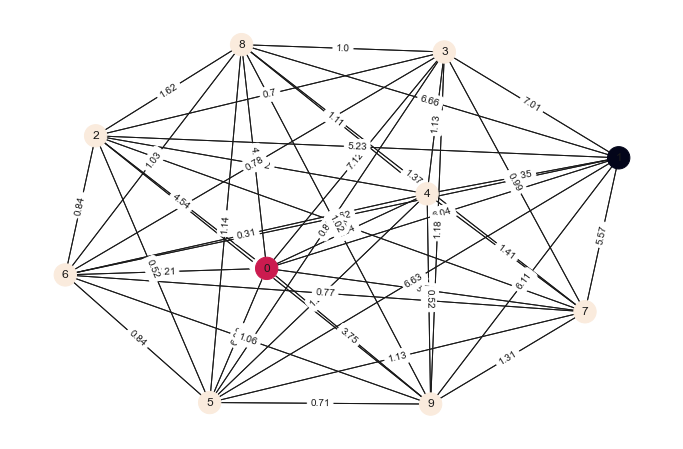

Total waste collected: equivalent to 1.94 trucks.
Total amount of gas used: 14.67 gallons.
Truck was operating for 3.64 hours (including 2.78 hours of driving).
Truck visited the drop-off site 3 times.


In [4]:
test = WasteRemovalSimulation(n=10, max_waste=0.5, strategy='random', dropoff=1)
test.observe()
res = test.run()
test.show_results()

In [5]:
class Test:
    """
    Tests the simulation by varying different parameters. Visualizes the outputs.
    """
    def __init__(self, strategy, n=20, max_waste=1, dropoff=1, trials=100):
        """
        Initializes basic properties of the test class.
        ----------------------------------
        strategy (str):
            strategy for the simulation (random or greedy)
        n (int):
            number of nodes in the graph
        max_waste (float):
            maximum waste amount that can be present on 1 farm 
            (measured as a proportion of a truck capacity)
        dropoff (int):
            number of dropoff sites in the system
        trials (int):
            number of times to run the simulation for
        """
        self.strategy = strategy
        self.n = n
        self.max_waste = max_waste
        self.dropoff = dropoff
        self.trials = trials
        # specify the parameter to vary
        self.varied_param = None
        # store the name of the varied parameter (for plotting)
        self.x = None
        
        # arrays to store values for metrics of interest
        self.sim_time = []
        self.time_CI = []
        
        self.sim_dump = []
        self.dump_CI = []
        
        self.sim_drive = []
        self.drive_CI = []
        
        self.sim_gas = []
        self.gas_CI = []
        
        self.avgs = None
        self.CIs = None

        
    def vary_n(self):
        """
        Varies the number of farms as a parameter of interest.
        Other metrics have default values.
        """
        self.varied_param = list(range(3, 31, 3))
        self.x = "Number of farms"
        for n in self.varied_param:
            avg_time = []
            avg_dumps = []
            avg_drive = []
            avg_gas = []
            for _ in range(self.trials):
                sim = WasteRemovalSimulation(n=n, max_waste=self.max_waste, 
                                             strategy=self.strategy, dropoff=self.dropoff)
                time, dumps, drive, gas = sim.run()
                avg_time.append(time)
                avg_dumps.append(dumps)
                avg_drive.append(drive)
                avg_gas.append(gas)
                
            self.sim_time.append(np.mean(avg_time))
            self.time_CI.append(1.96*(np.std(avg_time)/np.sqrt(self.trials)))
            
            self.sim_dump.append(np.mean(avg_dumps))
            self.dump_CI.append(1.96*(np.std(avg_dumps)/np.sqrt(self.trials)))
            
            self.sim_drive.append(np.mean(avg_drive))
            self.drive_CI.append(1.96*(np.std(avg_drive)/np.sqrt(self.trials)))
            
            self.sim_gas.append(np.mean(avg_gas))
            self.gas_CI.append(1.96*(np.std(avg_gas)/np.sqrt(self.trials)))
            
            self.avgs = [np.array(avg) for avg in [self.sim_time, self.sim_dump, 
                                                  self.sim_drive, self.sim_gas]]
            
            self.CIs = [np.array(ci) for ci in [self.time_CI, self.dump_CI, 
                                                  self.drive_CI, self.gas_CI]]
                
             
    def vary_max_waste(self):
        """
        Varies the maximum waste as a parameter of interest.
        Other metrics have default values.
        """
        self.varied_param = np.linspace(0.1, 1, 10)
        self.x = "Maximum waste"
        for w in self.varied_param:
            avg_time = []
            avg_dumps = []
            avg_drive = []
            avg_gas = []
            for _ in range(self.trials):
                sim = WasteRemovalSimulation(n=self.n, max_waste=w, 
                                             strategy=self.strategy, dropoff=self.dropoff)
                time, dumps, drive, gas = sim.run()
                avg_time.append(time)
                avg_dumps.append(dumps)
                avg_drive.append(drive)
                avg_gas.append(gas)
                
            self.sim_time.append(np.mean(avg_time))
            self.time_CI.append(1.96*(np.std(avg_time)/np.sqrt(self.trials)))
            
            self.sim_dump.append(np.mean(avg_dumps))
            self.dump_CI.append(1.96*(np.std(avg_dumps)/np.sqrt(self.trials)))
            
            self.sim_drive.append(np.mean(avg_drive))
            self.drive_CI.append(1.96*(np.std(avg_drive)/np.sqrt(self.trials)))
            
            self.sim_gas.append(np.mean(avg_gas))
            self.gas_CI.append(1.96*(np.std(avg_gas)/np.sqrt(self.trials)))
            
            self.avgs = [np.array(avg) for avg in [self.sim_time, self.sim_dump, 
                                                  self.sim_drive, self.sim_gas]]
            
            self.CIs = [np.array(ci) for ci in [self.time_CI, self.dump_CI, 
                                                  self.drive_CI, self.gas_CI]]
        
    def vary_dropoff(self):
        """
        Varies the number of drop-off sites as a parameter of interest.
        Other metrics have default values.
        """
        self.varied_param = list(range(1, 5))
        self.x = "Number of drop-off sites"
        for d in self.varied_param:
            avg_time = []
            avg_dumps = []
            avg_drive = []
            avg_gas = []
            for _ in range(self.trials):
                sim = WasteRemovalSimulation(n=self.n, max_waste=self.max_waste, 
                                             strategy=self.strategy, dropoff=d)
                time, dumps, drive, gas = sim.run()
                avg_time.append(time)
                avg_dumps.append(dumps)
                avg_drive.append(drive)
                avg_gas.append(gas)
                
            self.sim_time.append(np.mean(avg_time))
            self.time_CI.append(1.96*(np.std(avg_time)/np.sqrt(self.trials)))
            
            self.sim_dump.append(np.mean(avg_dumps))
            self.dump_CI.append(1.96*(np.std(avg_dumps)/np.sqrt(self.trials)))
            
            self.sim_drive.append(np.mean(avg_drive))
            self.drive_CI.append(1.96*(np.std(avg_drive)/np.sqrt(self.trials)))
            
            self.sim_gas.append(np.mean(avg_gas))
            self.gas_CI.append(1.96*(np.std(avg_gas)/np.sqrt(self.trials)))
            
            self.avgs = [np.array(avg) for avg in [self.sim_time, self.sim_dump, 
                                                  self.sim_drive, self.sim_gas]]
            
            self.CIs = [np.array(ci) for ci in [self.time_CI, self.dump_CI, 
                                                  self.drive_CI, self.gas_CI]]
        
        
    def plot_graphs(self, random_avg, random_ci, greedy_avg, greedy_ci):
        """
        Plots the graphs representing the relationships between 3 varied
        parameters and 4 metrics of interest collected during the simulation.
        """
        titles = ["Working Time (hours)", "Dump Visits",
                  "Driving Time (hours)", "Amount of Fuel Used (gallons)"]
        
        fig, axs = plt.subplots(2,2, figsize=(16, 14))
        axs = axs.flatten()
        
        for i in range(len(titles)):
            axs[i].plot(self.varied_param, random_avg[i], "-", label="random")
            axs[i].plot(self.varied_param, greedy_avg[i], "--", label="greedy")
            axs[i].fill_between(self.varied_param, (random_avg[i]-random_ci[i]), 
                                (random_avg[i]+random_ci[i]), color='blue', alpha=0.2)
            axs[i].fill_between(self.varied_param, (greedy_avg[i]-greedy_ci[i]), 
                                (greedy_avg[i]+greedy_ci[i]), color='orange', alpha=0.2)
            axs[i].set_title(f"Average {titles[i]}")
            axs[i].set_ylabel(titles[i])
            axs[i].set_xlabel(self.x)
            axs[i].legend()
        plt.show()
        
        
    def make_tables_graphs(self, random_avg, random_ci, greedy_avg, greedy_ci):
        """
        Creates tables showing the means and confidence intervals for every varied 
        parameter given 2 strategies (random and greedy).
        """
        titles = ["Working Time (hours)", "Dump Visits",
                  "Driving Time (hours)", "Amount of Fuel Used (gallons)"]
        colnames = [self.x, 'Random Avg', 'Random CI (+-)', 'Greedy Avg', 'Greedy CI (+-)']
        
        for i in range(len(titles)):
            print(f"Table {i+1}. Outcome variable: {titles[i]}. Varied parameter: {self.x}.")
            table = PrettyTable(colnames)
            for j in range(len(self.varied_param)):
                if self.varied_param[j] < 1:
                    self.varied_param[j] = np.round(self.varied_param[j], 1)
                table.add_row([self.varied_param[j], 
                           np.round(random_avg[i][j],2), np.round(random_ci[i][j], 2),
                           np.round(greedy_avg[i][j], 2), np.round(greedy_ci[i][j], 2)])
            print(table)
            print()
        
        
    def metric_distributions(self):
        """
        Displays average values for 4 metrics of interest without
        varying any values (all metrics have default values).
        """
        for _ in range(self.trials):
            sim = WasteRemovalSimulation(n=self.n, max_waste=self.max_waste, 
                                             strategy=self.strategy, dropoff=self.dropoff)
            time, dumps, drive, gas = sim.run()
            
            self.sim_time.append(time)
            self.time_CI.append(1.96*(np.std(time)/np.sqrt(self.trials)))

            self.sim_dump.append(dumps)
            self.time_CI.append(1.96*(np.std(dumps)/np.sqrt(self.trials)))

            self.sim_drive.append(drive)
            self.time_CI.append(1.96*(np.std(drive)/np.sqrt(self.trials)))
            
            self.sim_gas.append(gas)
            self.time_CI.append(1.96*(np.std(gas)/np.sqrt(self.trials)))
            
        self.avgs = [np.array(avg) for avg in [self.sim_time, self.sim_dump, 
                                              self.sim_drive, self.sim_gas]]
        self.CIs = [np.array(ci) for ci in [self.time_CI, self.dump_CI, 
                                                  self.drive_CI, self.gas_CI]]
        
    def plot_histograms(self, random_avgs, greedy_avgs):
        """
        Plots the histograms representing the distributions of 4 metrics of interest
        collected during the simulation.
        """
        titles = ["Working Time (hours)", "Dump Visits",
                  "Driving Time (hours)", "Amount of Fuel Used (gallons)"]
        
        fig, axs = plt.subplots(4,2, figsize=(24, 32))
        axs = axs.flatten()

        for i in range(len(titles)*2): 
            if i % 2 == 0:
                axs[i].hist(random_avgs[i // 2])
                axs[i].set_title(f"Distribution of {titles[i // 2]}: random", fontsize=16)
            else:
                axs[i].hist(greedy_avgs[i // 2])
                axs[i].set_title(f"Distribution of {titles[i // 2]}: greedy", fontsize=16)
            axs[i].set_xlabel(titles[i // 2], fontsize=14)
            axs[i].set_ylabel("Frequency", fontsize=14)
        plt.show()
        
        
    def make_tables_histograms(self, random_avgs, random_cis, greedy_avgs, greedy_cis):
        """
        Creates tables showing the means and confidence intervals for 4 metrics of interest
        using their default values. Then, compares both strategies and shows by how much
        one is more efficient over the other.
        """
        titles = ["Working Time (hours)", "Dump Visits",
                  "Driving Time (hours)", "Amount of Fuel Used (gallons)"]
        colnames = ['Metric', 'Random Avg', 'Greedy Avg']
        table = PrettyTable(colnames)
        print('Table 1: Mean values for all metrics of interest.')
        for i in range(len(titles)):
            table.add_row([titles[i], np.round(np.mean(random_avgs[i]),2), 
                           np.round(np.mean(greedy_avgs[i]),2)])
        print(table)
        print()
        
        colnames2 = ["Metric", "Greedy over Random (%)"]
        table2 = PrettyTable(colnames2)
        print("Table 2. Comparison of 2 strategies for all metrics of interest.")
        for j in range(len(titles)):
            table2.add_row([titles[j], 
                           np.round((abs(np.mean(greedy_avgs[j]) - 
                                         np.mean(random_avgs[j]))/np.mean(random_avgs[j]))*100, 2)])
        print(table2)

I would like to acknowledge the help I received from Isabel Brunkan (M23) (specifically, I discussed the calculation of confidence intervals for 4 chosen metrics and displaying with strategy is better in % through the tables shown below).

### Testing the number of farms

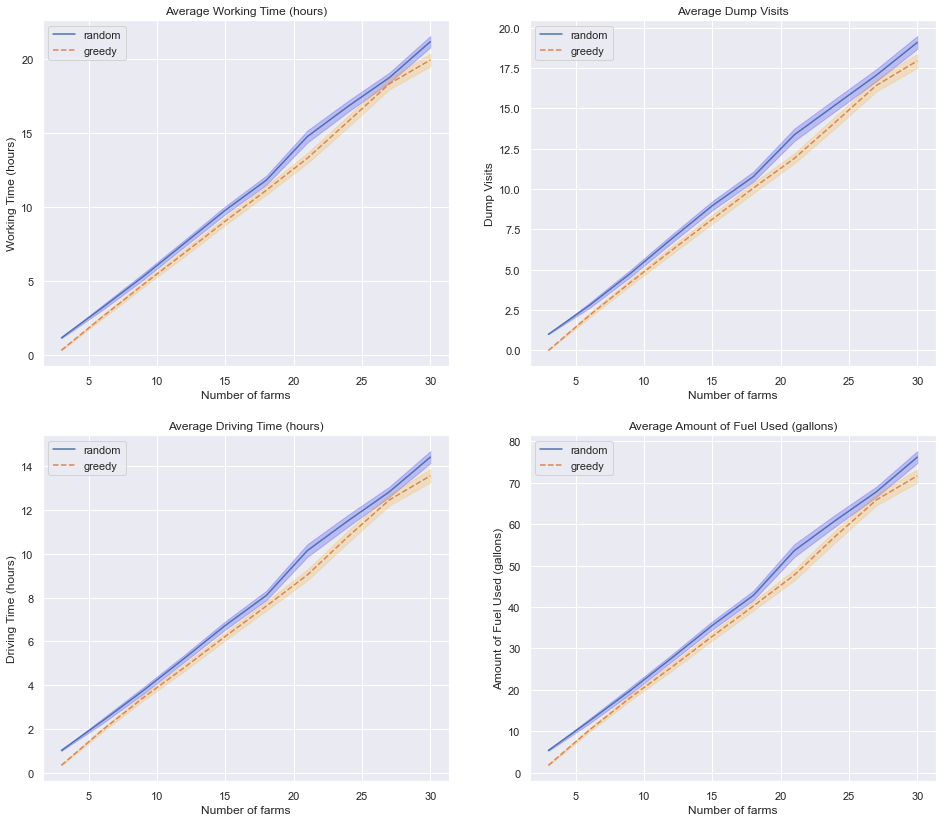

In [6]:
farms_random = Test('random')
farms_random.vary_n()
farms_greedy = Test('greedy')
farms_greedy.vary_n()
farms_random.plot_graphs(farms_random.avgs, farms_random.CIs,
                         farms_greedy.avgs, farms_greedy.CIs)
print()

In [7]:
farms_random.make_tables_graphs(farms_random.avgs, farms_random.CIs,
                         farms_greedy.avgs, farms_greedy.CIs)

Table 1. Outcome variable: Working Time (hours). Varied parameter: Number of farms.
+-----------------+------------+----------------+------------+----------------+
| Number of farms | Random Avg | Random CI (+-) | Greedy Avg | Greedy CI (+-) |
+-----------------+------------+----------------+------------+----------------+
|        3        |    1.18    |      0.03      |    0.34    |      0.01      |
|        6        |    3.22    |      0.16      |    2.6     |      0.13      |
|        9        |    5.33    |      0.22      |    4.79    |      0.18      |
|        12       |    7.57    |      0.22      |    6.92    |      0.24      |
|        15       |    9.81    |      0.27      |    9.07    |      0.27      |
|        18       |   11.84    |      0.31      |   11.16    |      0.3       |
|        21       |   14.79    |      0.41      |   13.32    |      0.34      |
|        24       |   16.84    |      0.37      |   15.82    |      0.38      |
|        27       |   18.77    |    

### Testing the maximum waste value

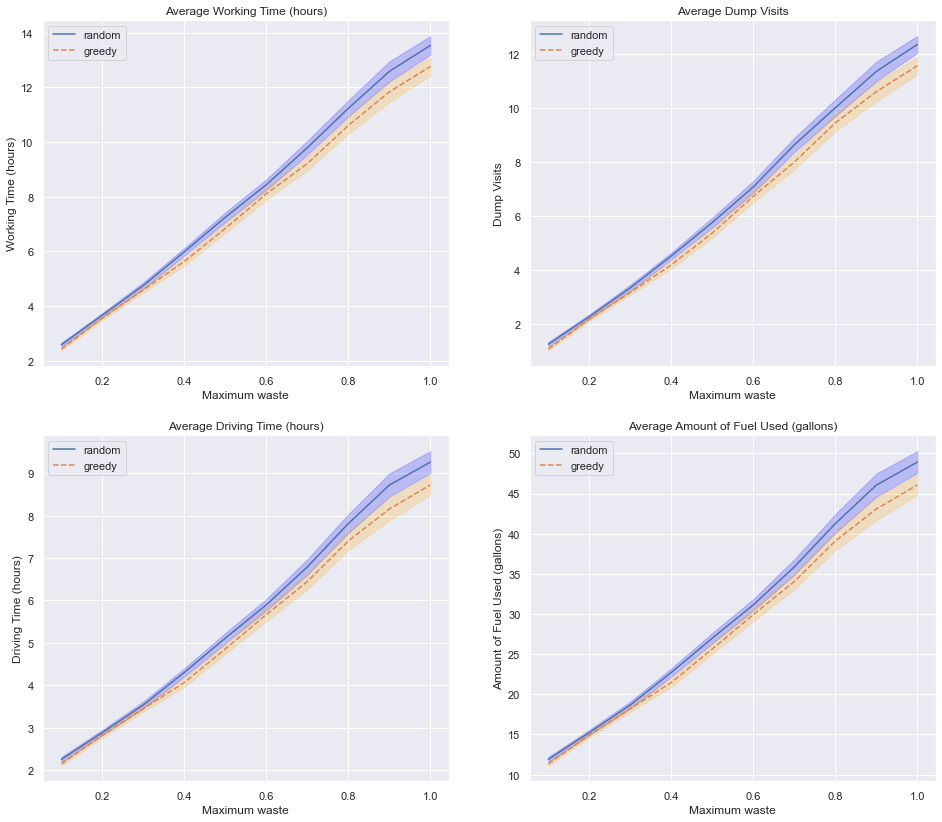

In [8]:
waste_random = Test('random')
waste_random.vary_max_waste()
waste_greedy = Test('greedy')
waste_greedy.vary_max_waste()
waste_random.plot_graphs(waste_random.avgs, waste_random.CIs,
                         waste_greedy.avgs, waste_greedy.CIs)
print()

In [9]:
waste_random.make_tables_graphs(waste_random.avgs, waste_random.CIs,
                         waste_greedy.avgs, waste_greedy.CIs)

Table 1. Outcome variable: Working Time (hours). Varied parameter: Maximum waste.
+---------------+------------+----------------+------------+----------------+
| Maximum waste | Random Avg | Random CI (+-) | Greedy Avg | Greedy CI (+-) |
+---------------+------------+----------------+------------+----------------+
|      0.1      |    2.59    |      0.08      |    2.43    |      0.05      |
|      0.2      |    3.67    |      0.08      |    3.56    |      0.08      |
|      0.3      |    4.76    |      0.12      |    4.59    |      0.09      |
|      0.4      |    5.99    |      0.14      |    5.63    |      0.15      |
|      0.5      |    7.25    |      0.18      |    6.84    |      0.17      |
|      0.6      |    8.44    |      0.2       |    8.11    |      0.22      |
|      0.7      |    9.79    |      0.25      |    9.21    |      0.25      |
|      0.8      |   11.23    |      0.29      |   10.61    |      0.3       |
|      0.9      |   12.58    |      0.37      |   11.83    |

### Testing the number of drop-off sites

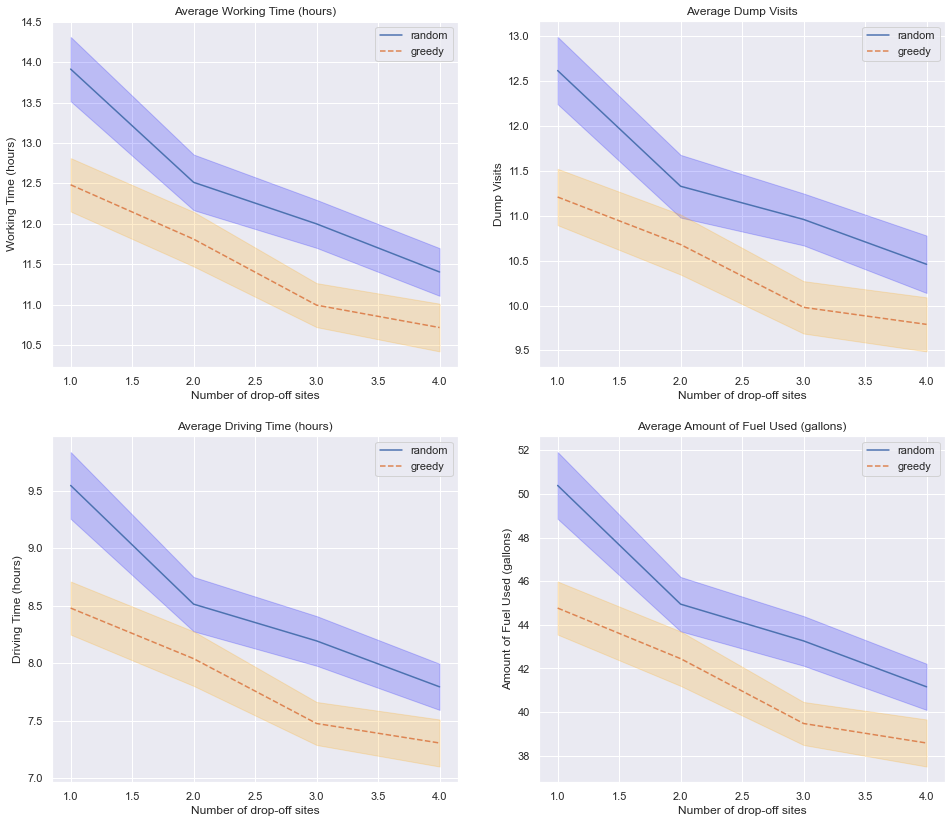

In [10]:
dropoff_random = Test('random')
dropoff_random.vary_dropoff()
dropoff_greedy = Test('greedy')
dropoff_greedy.vary_dropoff()
dropoff_random.plot_graphs(dropoff_random.avgs, dropoff_random.CIs,
                         dropoff_greedy.avgs, dropoff_greedy.CIs)
print()

In [11]:
dropoff_random.make_tables_graphs(dropoff_random.avgs, dropoff_random.CIs,
                         dropoff_greedy.avgs, dropoff_greedy.CIs)

Table 1. Outcome variable: Working Time (hours). Varied parameter: Number of drop-off sites.
+--------------------------+------------+----------------+------------+----------------+
| Number of drop-off sites | Random Avg | Random CI (+-) | Greedy Avg | Greedy CI (+-) |
+--------------------------+------------+----------------+------------+----------------+
|            1             |   13.92    |      0.4       |   12.48    |      0.33      |
|            2             |   12.51    |      0.34      |   11.81    |      0.34      |
|            3             |    12.0    |      0.3       |   10.99    |      0.27      |
|            4             |    11.4    |      0.3       |   10.72    |      0.3       |
+--------------------------+------------+----------------+------------+----------------+

Table 2. Outcome variable: Dump Visits. Varied parameter: Number of drop-off sites.
+--------------------------+------------+----------------+------------+----------------+
| Number of drop-off 

### Testing the metrics distributions

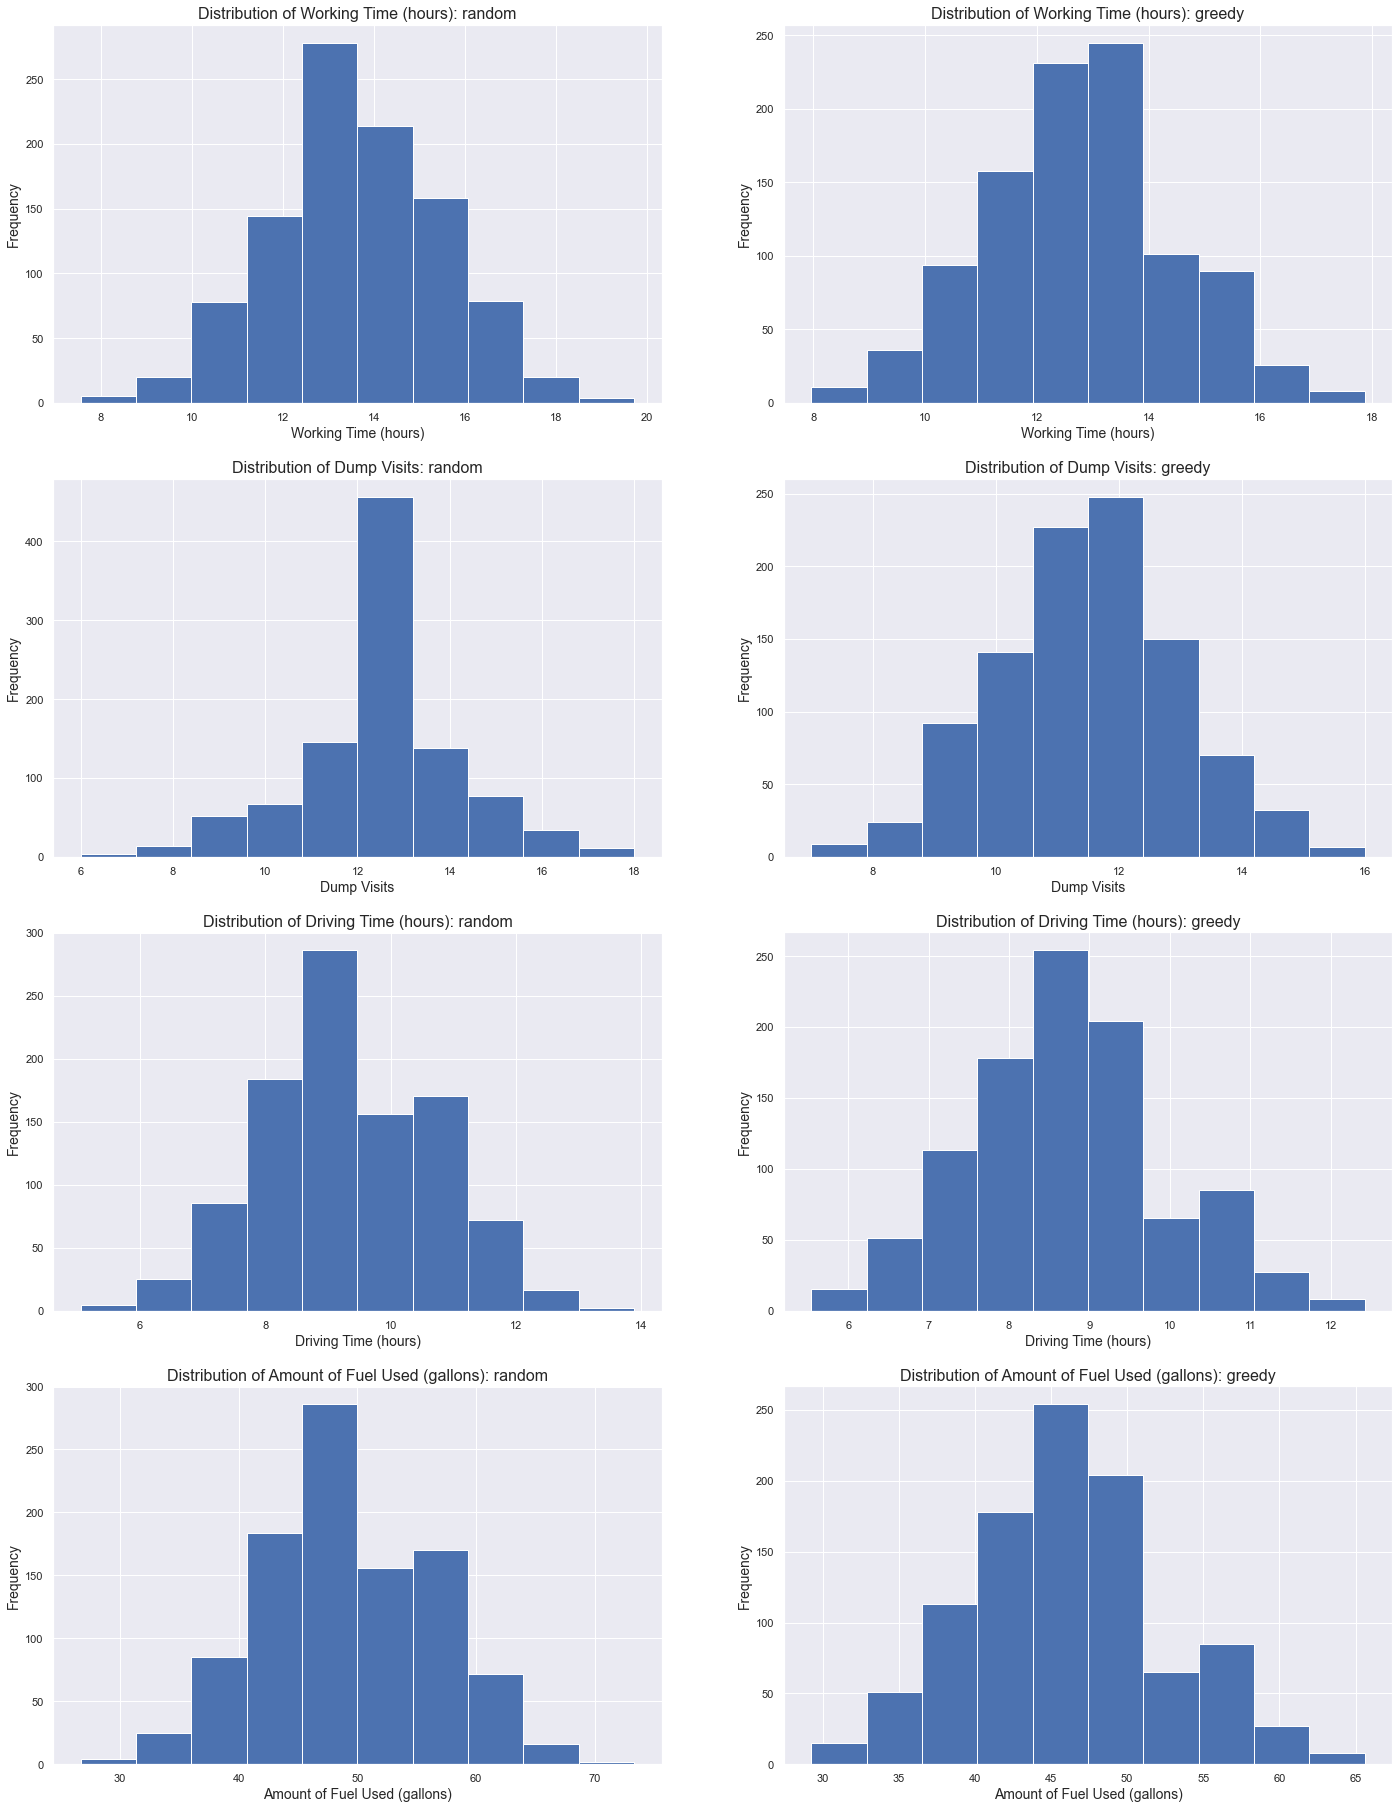

In [12]:
random_data = Test('random', trials=1000)
random_data.metric_distributions()
greedy_data = Test('greedy', trials=1000)
greedy_data.metric_distributions()
random_data.plot_histograms(random_data.avgs, greedy_data.avgs)

In [13]:
random_data.make_tables_histograms(random_data.avgs, random_data.CIs,
                                   greedy_data.avgs, greedy_data.CIs)

Table 1: Mean values for all metrics of interest.
+-------------------------------+------------+------------+
|             Metric            | Random Avg | Greedy Avg |
+-------------------------------+------------+------------+
|      Working Time (hours)     |   13.62    |   12.77    |
|          Dump Visits          |   12.43    |   11.49    |
|      Driving Time (hours)     |    9.32    |    8.7     |
| Amount of Fuel Used (gallons) |   49.22    |   45.95    |
+-------------------------------+------------+------------+

Table 2. Comparison of 2 strategies for all metrics of interest.
+-------------------------------+------------------------+
|             Metric            | Greedy over Random (%) |
+-------------------------------+------------------------+
|      Working Time (hours)     |          6.2           |
|          Dump Visits          |          7.57          |
|      Driving Time (hours)     |          6.64          |
| Amount of Fuel Used (gallons) |          6.64   